In [1]:
from matplotlib import pyplot as plt
import numpy as np

In [2]:
from lstm_policy import pad_and_concat
from dpll import DPLL, RandomClauseDPLL, MostCommonVarDPLL, RandomVarDPLL
from cnf import get_random_kcnf, CNF

In [3]:
np.set_printoptions(precision=2, suppress=True)

In [4]:
import tensorflow as tf
import os

BATCH_SIZE = 64

# META_FILE = "series/18-03-24-020248/var5/models/activepolicy-18-03-24-020450/model-32000000.meta"  # perfect results
# META_FILE = "series/18-03-24-020248/var7/models/activepolicy-18-03-24-020450/model-6400000.meta" # ok results, no error > 80% usually, usually better than mostcommon
META_FILE = "series/18-03-24-020248/var8/models/activepolicy-18-03-24-020450/model-6400000.meta"  # usually slightly worse than mostcommon

sess=tf.Session()    
#First let's load meta graph and restore weights
saver = tf.train.import_meta_graph(META_FILE)
sess.run(tf.global_variables_initializer())
saver.restore(sess, tf.train.latest_checkpoint(os.path.dirname(META_FILE)))

# Now, let's access and create placeholders variables and
# create feed-dict to feed new data

graph = tf.get_default_graph()

INFO:tensorflow:Restoring parameters from series/18-03-24-020248/var8/models/activepolicy-18-03-24-020450/model-6400000


In [5]:
g_inputs = graph.get_tensor_by_name("inputs:0")
g_lengths = graph.get_tensor_by_name("lengths:0")

In [6]:
g_policy_probs = graph.get_tensor_by_name('policy_prob:0')
g_sat_probs = graph.get_tensor_by_name('sat_prob:0')

In [7]:
np.set_printoptions(precision=3, suppress=True)

In [8]:
inputs = np.asarray([[[1, 1, 3], [1, -3, 2], [1, 3, 4], [-2, -3, 4]]] * BATCH_SIZE, dtype=np.int32)
lengths = np.asarray([inputs.shape[1]] * 64, dtype=np.int32)

sat_prob, policy_probs = sess.run([g_sat_probs, g_policy_probs], feed_dict={g_inputs: inputs, g_lengths: lengths})

print(sat_prob[0], policy_probs[0])

0.99999034 [1.    0.982 0.999 0.994 0.998 0.988 1.    0.994 0.    0.    0.001 0.001
 0.    0.    0.    0.   ]


In [9]:
# Because we have to pass full batch

logfile = open("/tmp/log", "w")

class LSTMBasedDPLL(DPLL):
    def suggest(self, input_cnf: CNF):
        cnfs = [input_cnf] * BATCH_SIZE
        cnfs_clauses = [[claus + tuple([claus[0]] * (3-len(claus))) for claus in cnf.clauses] for cnf in cnfs]
        inputs, lengths = pad_and_concat(cnfs_clauses)
        
        policy_probs = sess.run(g_policy_probs, feed_dict={g_inputs: inputs, g_lengths: lengths})
        
        print("CNF:", input_cnf, end=' ', file=logfile)
        print('cnf_clauses[0]', cnfs_clauses[0], end=' ', file=logfile)
        print("probs:",  policy_probs[0], end=' \n', file=logfile)
        
        best_prob = 0.0
        best_svar = None
        for var in input_cnf.vars:
            for svar in [var, -var]:
                svar_prob = policy_probs[0][(var-1)*2 + (0 if svar > 0 else 1)]
                print(svar, svar_prob, best_prob, file=logfile)
                if svar_prob > best_prob:
                    best_prob = svar_prob
                    best_svar = svar
        print("best_svar:", best_svar, file=logfile)
        return best_svar

In [10]:
def compute_steps(sats, dpll_cls):
    steps = []
    errors = []
    for sat in sats:
        dpll = dpll_cls()
        res = dpll.run(sat)
        assert res is not None
        steps.append(dpll.number_of_runs)
        errors.append(dpll.number_of_errors)
    return steps, errors

In [11]:
def compute_and_print_steps(sats, dpll_cls):
    steps, errors = compute_steps(sats, dpll_cls)
    print("#Sats: {}; avg step: {:.2f}; stdev step: {:.2f}; avg error: {:.2f}; stdev error: {:.2f}".format(
        len(steps), np.mean(steps), np.std(steps), np.mean(errors), np.std(errors)))
    plt.figure(figsize=(14, 4))
    plt.subplot(1, 2, 1)
    plt.title("Steps of {}".format(dpll_cls.__name__))
    plt.hist(steps, bins=range(2**(N+1)))
    plt.ylim((0, len(sats)))
    
    plt.subplot(1, 2, 2)
    plt.title("Errors of {}".format(dpll_cls.__name__))
    plt.hist(errors, bins=range(N+1))
    plt.ylim((0, len(sats)))
    plt.show()

In [12]:
def print_all(s, k, n, m):
    global S, K, N, M
    S = s
    K = k
    N = n
    M = m
    
    MAX_TRIES = 100000
    sats = []
    for index in range(MAX_TRIES):
        if len(sats) >= S:
            break
        sat = get_random_kcnf(K, N, M)
        if DPLL().run(sat) is not None:
            sats.append(sat)
    assert len(sats) == S
    compute_and_print_steps(sats, DPLL)
    compute_and_print_steps(sats, RandomVarDPLL)
    compute_and_print_steps(sats, RandomClauseDPLL)
    compute_and_print_steps(sats, LSTMBasedDPLL)
    compute_and_print_steps(sats, MostCommonVarDPLL)
    logfile.flush()

#Sats: 400; avg step: 3.75; stdev step: 1.19; avg error: 0.65; stdev error: 0.64


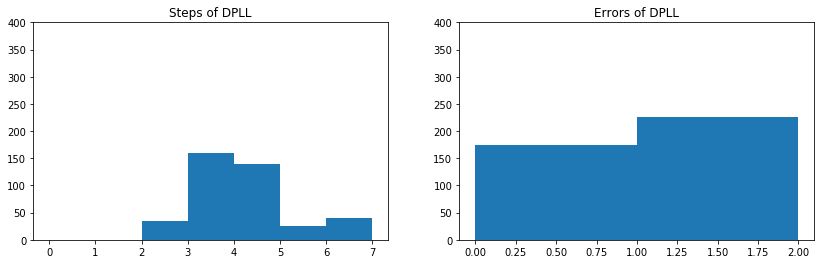

#Sats: 400; avg step: 3.67; stdev step: 1.15; avg error: 0.65; stdev error: 0.64


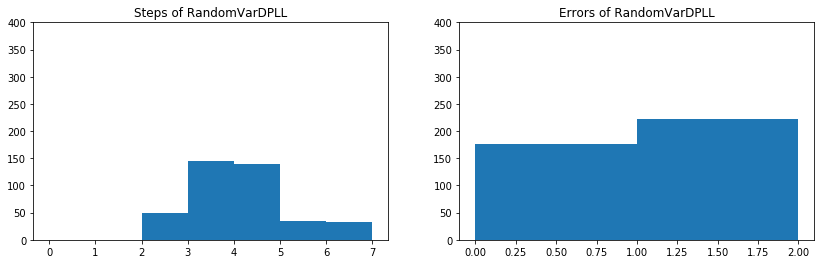

#Sats: 400; avg step: 3.01; stdev step: 0.82; avg error: 0.16; stdev error: 0.37


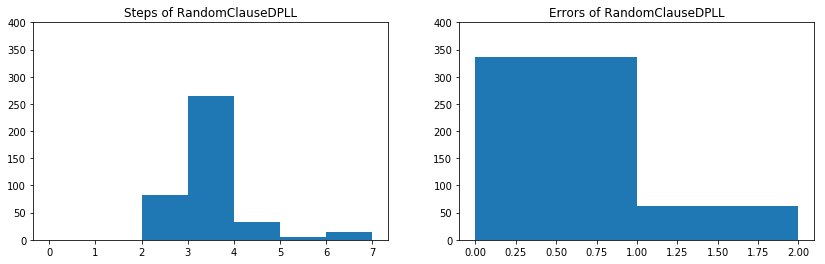

#Sats: 400; avg step: 3.02; stdev step: 0.82; avg error: 0.06; stdev error: 0.24


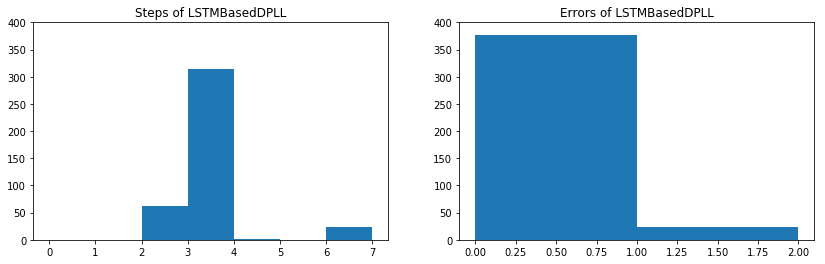

#Sats: 400; avg step: 2.64; stdev step: 0.49; avg error: 0.01; stdev error: 0.07


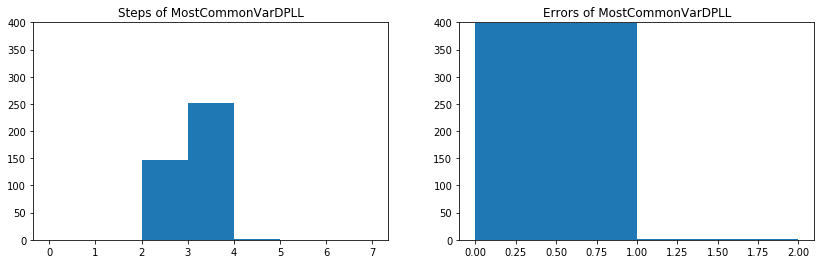

In [13]:
print_all(400, 2, 2, 3)

#Sats: 100; avg step: 8.22; stdev step: 2.72; avg error: 1.84; stdev error: 1.01


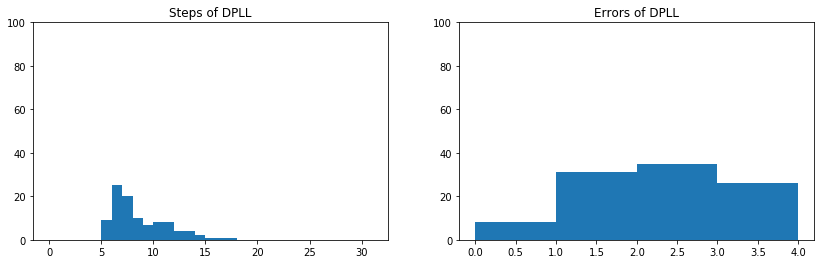

#Sats: 100; avg step: 8.20; stdev step: 2.73; avg error: 1.95; stdev error: 0.97


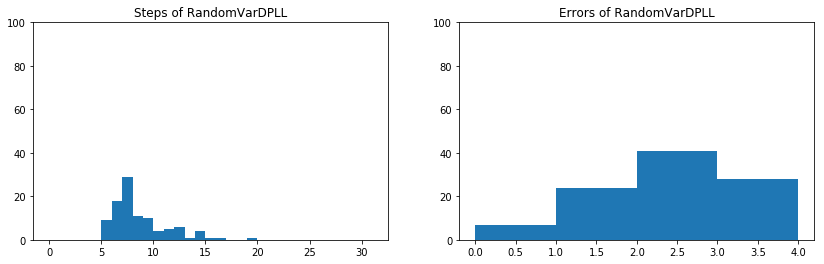

#Sats: 100; avg step: 7.62; stdev step: 2.86; avg error: 1.13; stdev error: 0.84


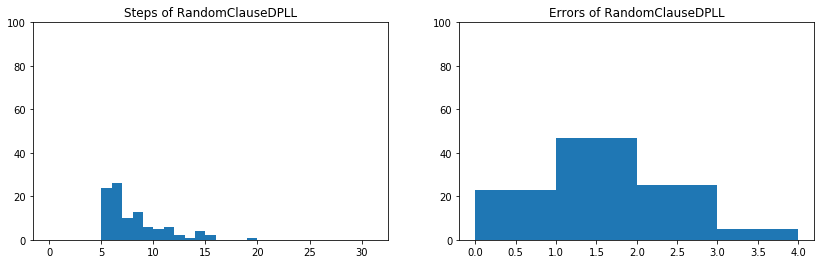

#Sats: 100; avg step: 5.46; stdev step: 1.54; avg error: 0.12; stdev error: 0.35


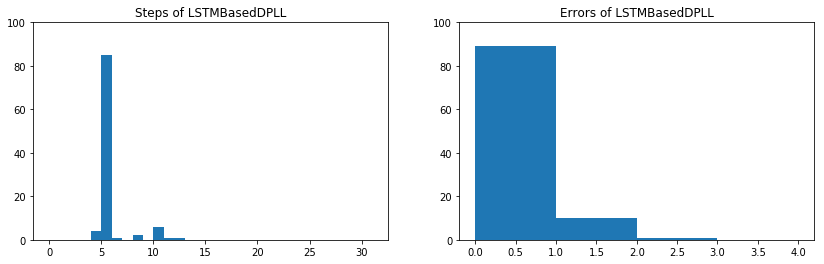

#Sats: 100; avg step: 5.07; stdev step: 0.84; avg error: 0.07; stdev error: 0.26


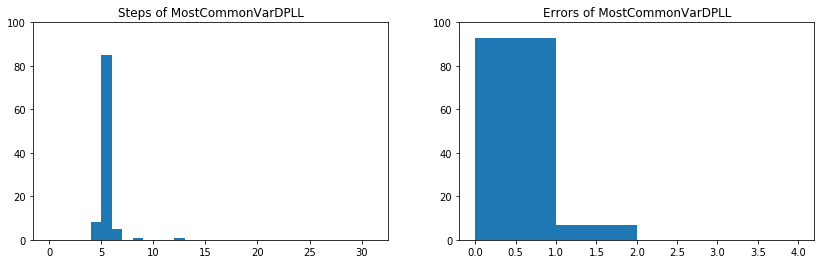

In [14]:
print_all(100, 2, 4, 20)

#Sats: 100; avg step: 7.40; stdev step: 3.59; avg error: 1.00; stdev error: 0.85


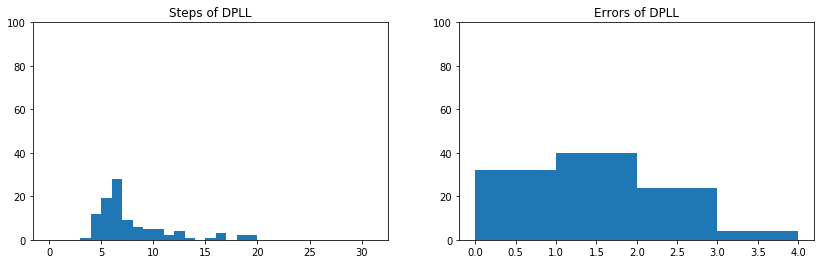

#Sats: 100; avg step: 7.33; stdev step: 3.27; avg error: 1.10; stdev error: 0.81


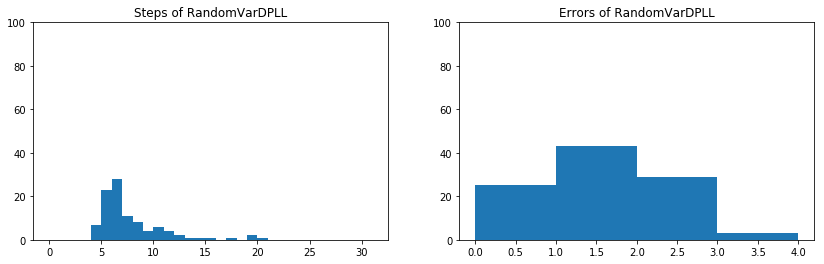

#Sats: 100; avg step: 5.92; stdev step: 2.59; avg error: 0.39; stdev error: 0.56


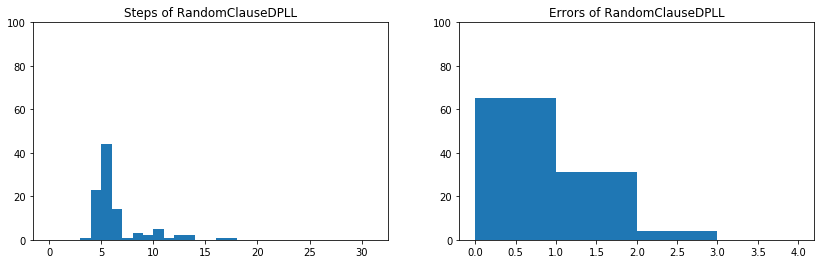

#Sats: 100; avg step: 5.24; stdev step: 1.94; avg error: 0.09; stdev error: 0.29


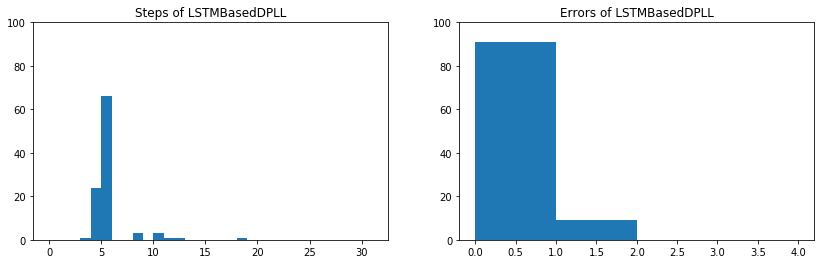

#Sats: 100; avg step: 4.45; stdev step: 1.40; avg error: 0.12; stdev error: 0.35


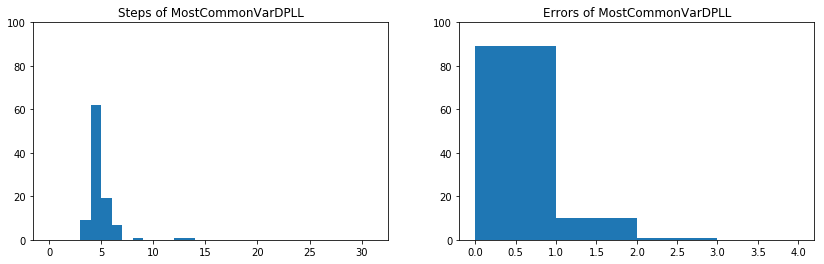

In [15]:
print_all(100, 3, 4, 10)

#Sats: 100; avg step: 10.56; stdev step: 4.57; avg error: 1.91; stdev error: 1.00


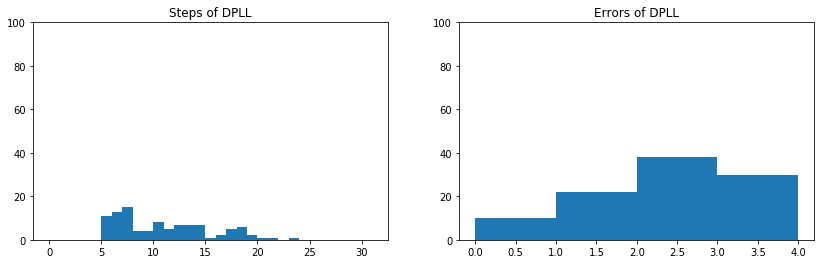

#Sats: 100; avg step: 11.39; stdev step: 5.08; avg error: 1.94; stdev error: 0.94


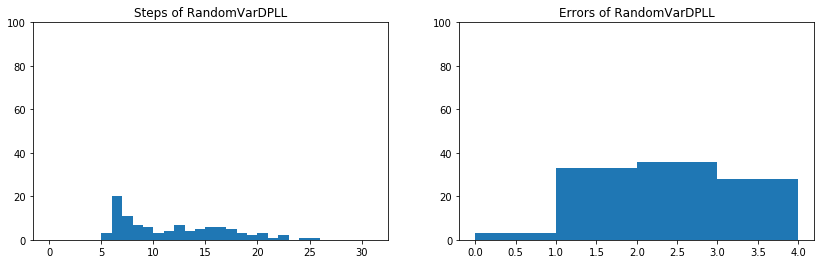

#Sats: 100; avg step: 8.42; stdev step: 4.15; avg error: 1.00; stdev error: 0.85


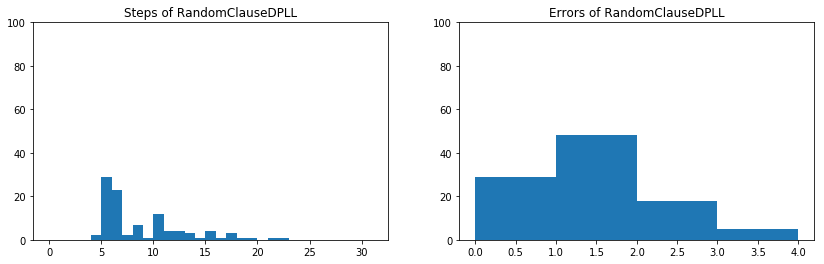

#Sats: 100; avg step: 7.87; stdev step: 4.63; avg error: 0.41; stdev error: 0.53


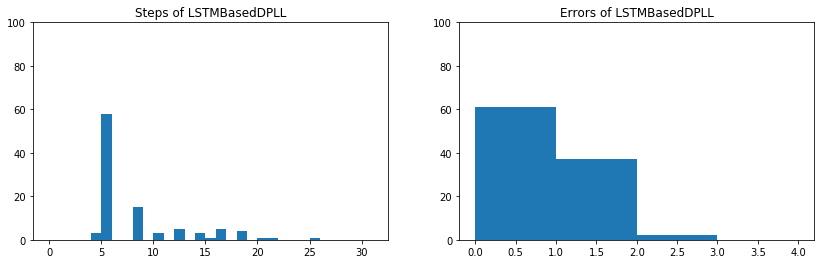

#Sats: 100; avg step: 6.80; stdev step: 3.81; avg error: 0.43; stdev error: 0.62


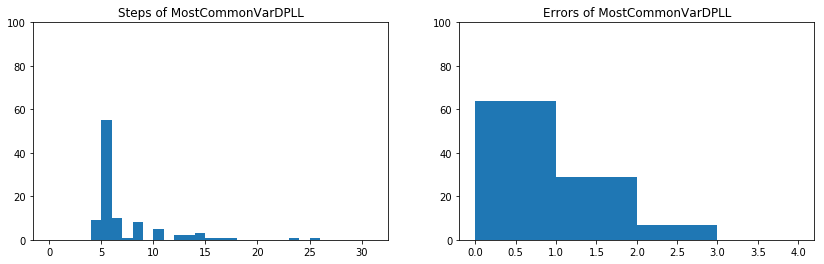

In [16]:
print_all(100, 3, 4, 20)

#Sats: 100; avg step: 10.50; stdev step: 4.04; avg error: 2.10; stdev error: 1.00


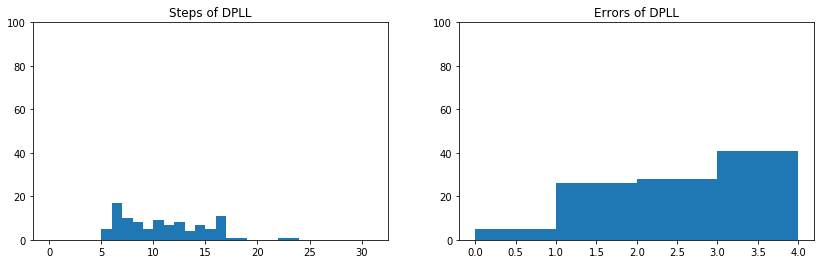

#Sats: 100; avg step: 10.25; stdev step: 3.49; avg error: 1.99; stdev error: 0.93


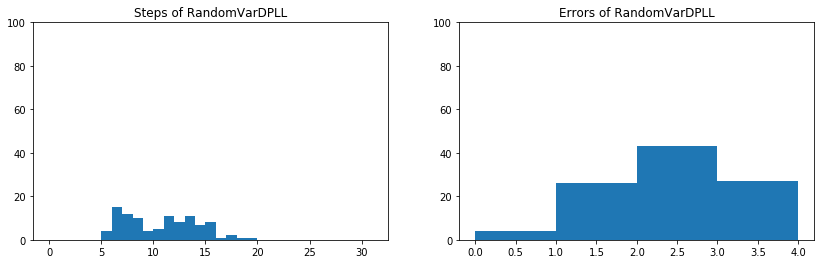

#Sats: 100; avg step: 8.99; stdev step: 3.48; avg error: 1.23; stdev error: 0.81


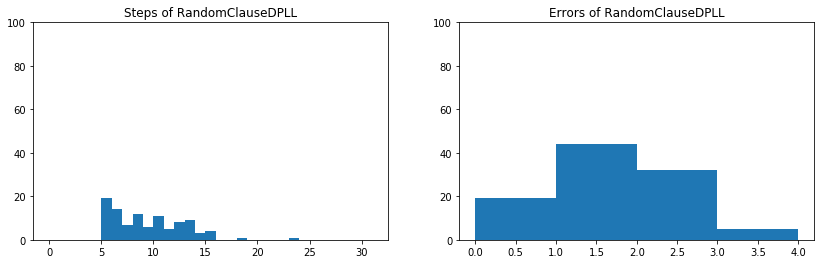

#Sats: 100; avg step: 7.11; stdev step: 3.59; avg error: 0.35; stdev error: 0.52


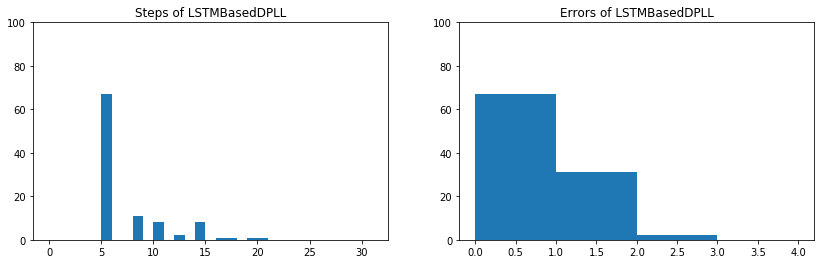

#Sats: 100; avg step: 6.13; stdev step: 2.45; avg error: 0.34; stdev error: 0.53


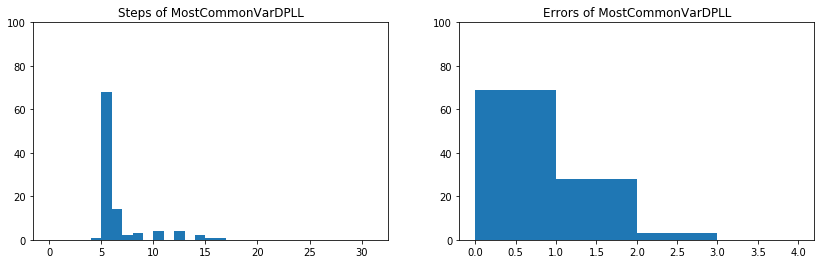

In [17]:
print_all(100, 3, 4, 40)

#Sats: 100; avg step: 13.82; stdev step: 6.66; avg error: 2.20; stdev error: 1.21


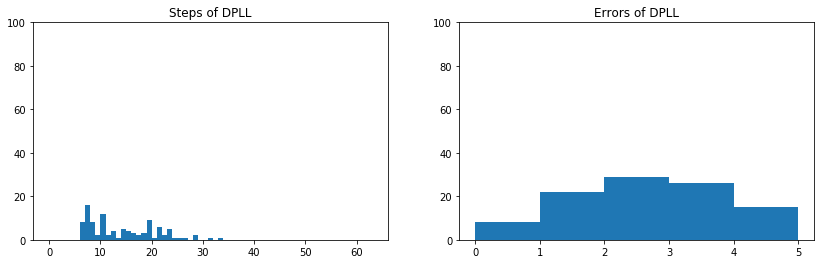

#Sats: 100; avg step: 15.37; stdev step: 7.91; avg error: 2.30; stdev error: 1.18


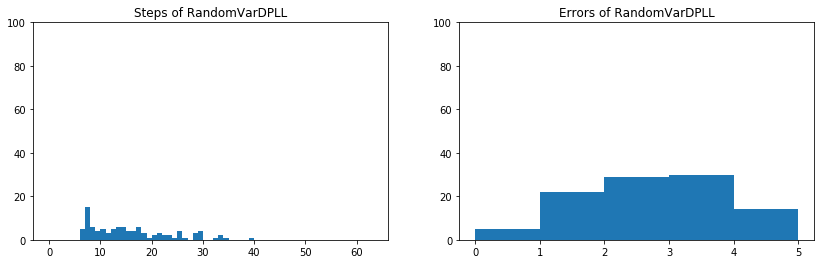

#Sats: 100; avg step: 11.28; stdev step: 5.84; avg error: 1.22; stdev error: 0.93


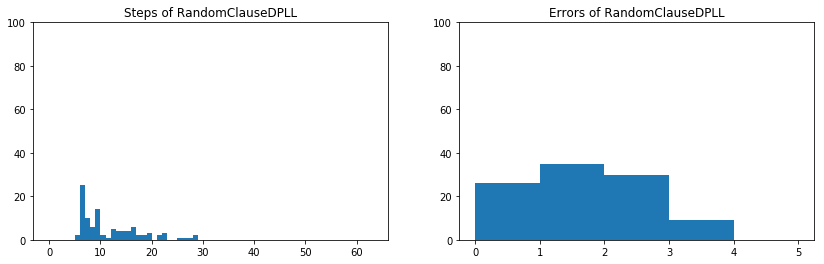

#Sats: 100; avg step: 9.76; stdev step: 6.59; avg error: 0.37; stdev error: 0.54


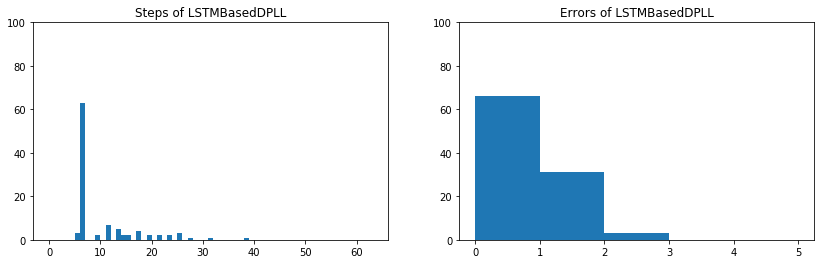

#Sats: 100; avg step: 7.93; stdev step: 4.01; avg error: 0.46; stdev error: 0.61


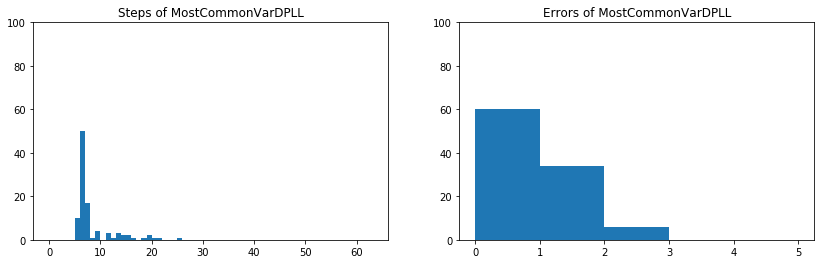

In [18]:
print_all(100, 3, 5, 30)

#Sats: 100; avg step: 15.12; stdev step: 6.03; avg error: 2.54; stdev error: 1.05


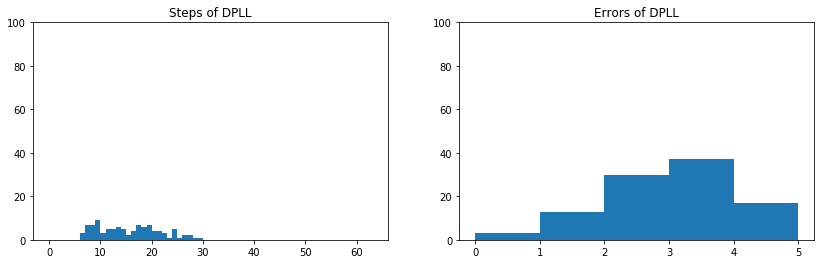

#Sats: 100; avg step: 14.44; stdev step: 6.53; avg error: 2.56; stdev error: 1.16


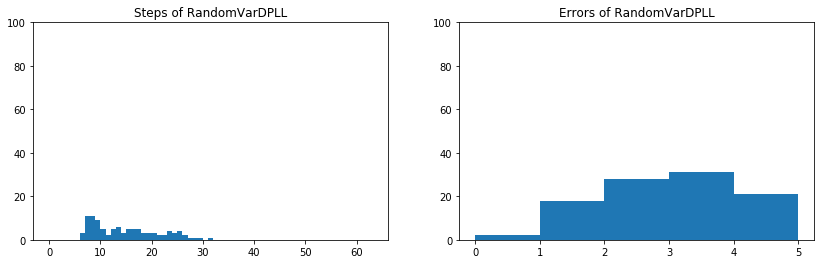

#Sats: 100; avg step: 12.28; stdev step: 6.36; avg error: 1.43; stdev error: 0.96


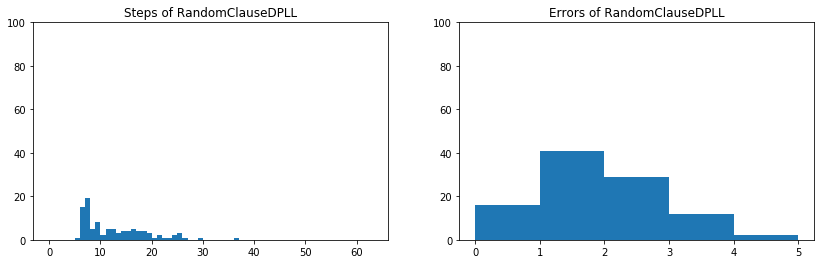

#Sats: 100; avg step: 9.04; stdev step: 5.28; avg error: 0.35; stdev error: 0.52


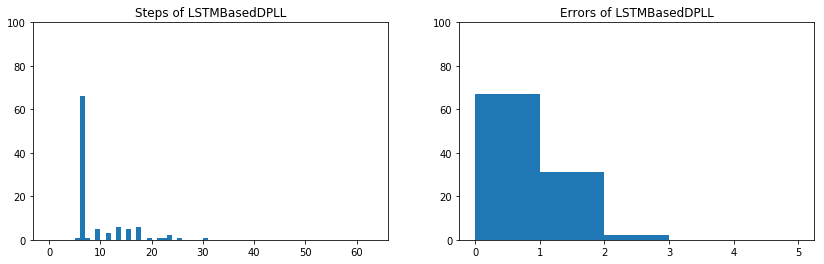

#Sats: 100; avg step: 7.43; stdev step: 2.83; avg error: 0.38; stdev error: 0.54


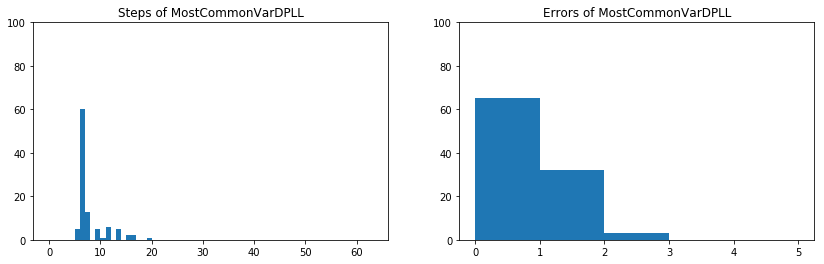

In [19]:
print_all(100, 3, 5, 40)

#Sats: 100; avg step: 20.21; stdev step: 11.63; avg error: 2.57; stdev error: 1.19


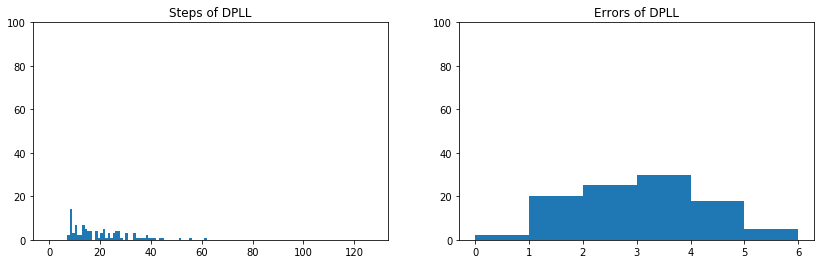

#Sats: 100; avg step: 20.25; stdev step: 10.39; avg error: 2.87; stdev error: 1.21


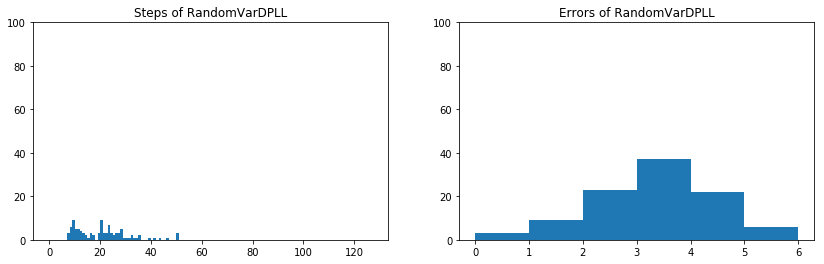

#Sats: 100; avg step: 17.02; stdev step: 9.88; avg error: 1.79; stdev error: 1.14


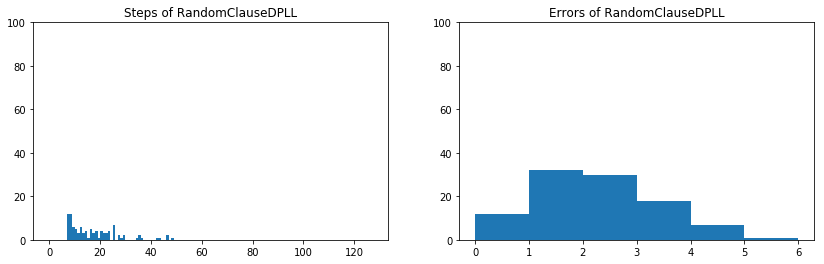

#Sats: 100; avg step: 11.64; stdev step: 8.52; avg error: 0.41; stdev error: 0.57


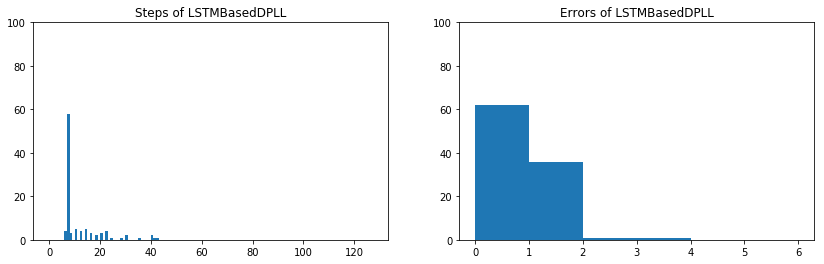

#Sats: 100; avg step: 10.27; stdev step: 5.26; avg error: 0.59; stdev error: 0.62


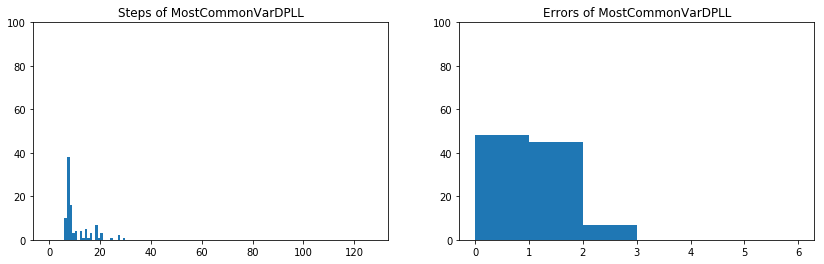

In [20]:
print_all(100, 3, 6, 40)

#Sats: 100; avg step: 15.43; stdev step: 7.91; avg error: 2.69; stdev error: 1.30


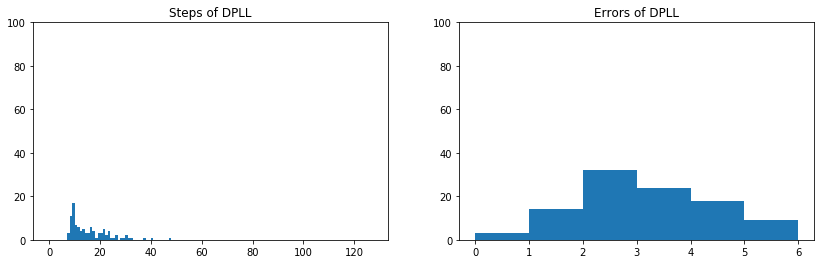

#Sats: 100; avg step: 17.87; stdev step: 7.10; avg error: 2.97; stdev error: 1.26


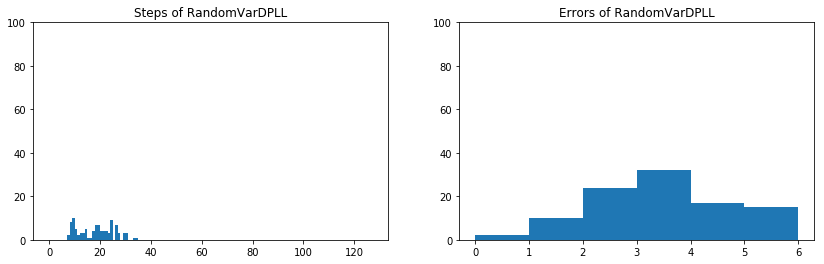

#Sats: 100; avg step: 13.85; stdev step: 6.76; avg error: 1.65; stdev error: 1.17


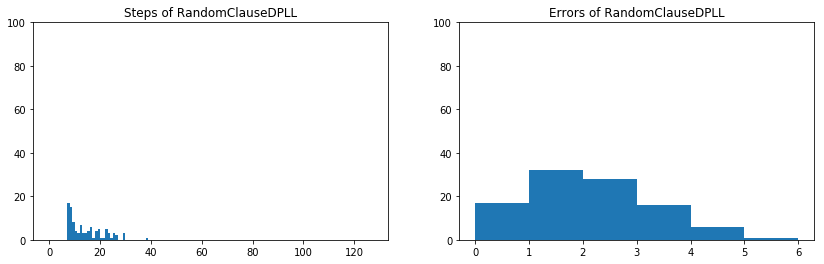

#Sats: 100; avg step: 11.62; stdev step: 6.88; avg error: 0.56; stdev error: 0.71


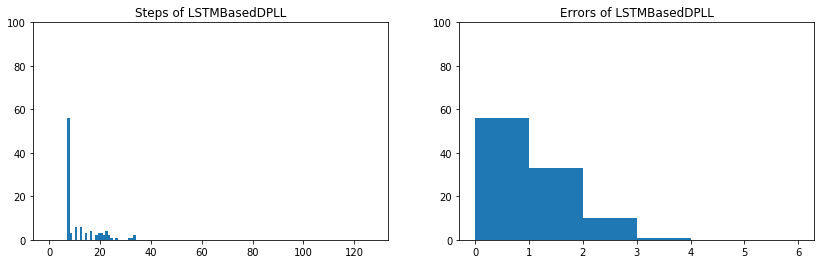

#Sats: 100; avg step: 8.47; stdev step: 3.17; avg error: 0.33; stdev error: 0.49


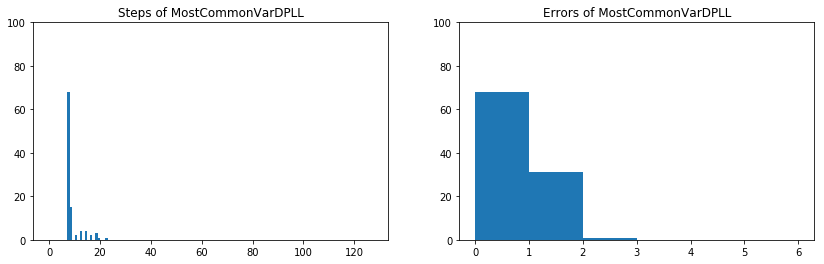

In [21]:
print_all(100, 3, 6, 70)

#Sats: 100; avg step: 20.95; stdev step: 16.35; avg error: 2.08; stdev error: 1.19


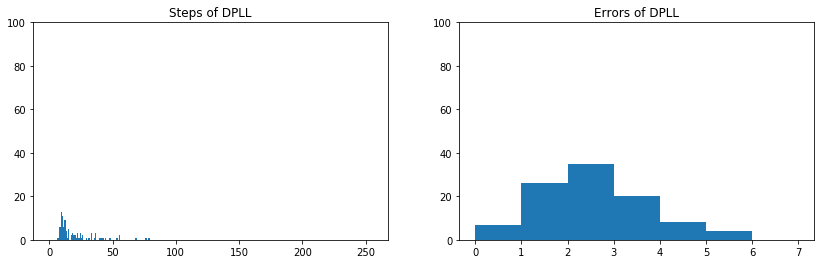

#Sats: 100; avg step: 20.84; stdev step: 13.52; avg error: 2.30; stdev error: 1.20


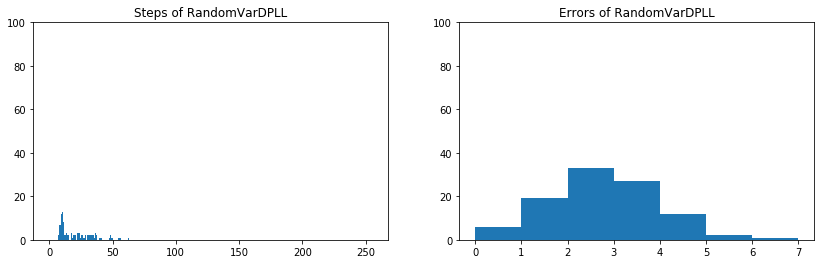

#Sats: 100; avg step: 11.99; stdev step: 7.91; avg error: 0.84; stdev error: 0.88


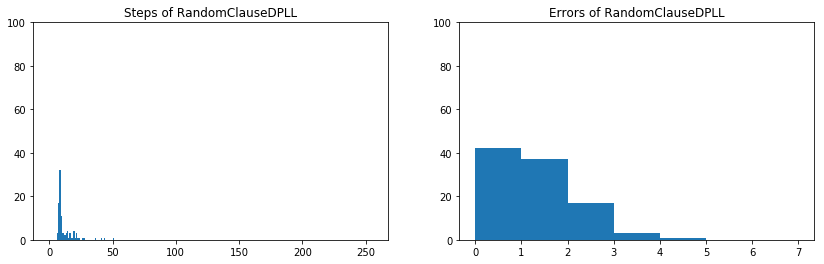

#Sats: 100; avg step: 12.38; stdev step: 13.36; avg error: 0.24; stdev error: 0.47


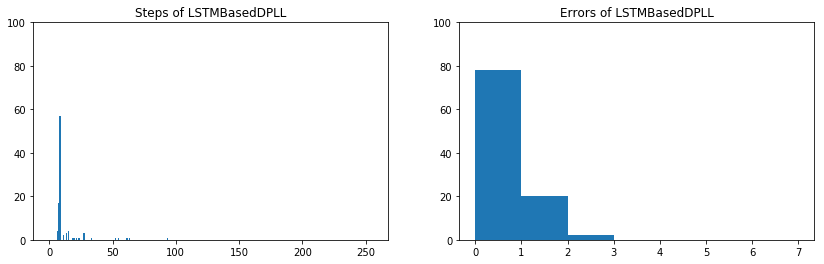

#Sats: 100; avg step: 8.06; stdev step: 4.80; avg error: 0.23; stdev error: 0.49


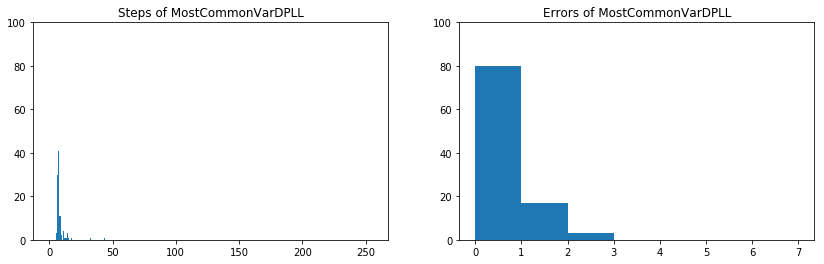

In [22]:
print_all(100, 3, 7, 20)

#Sats: 100; avg step: 23.61; stdev step: 10.48; avg error: 3.39; stdev error: 1.38


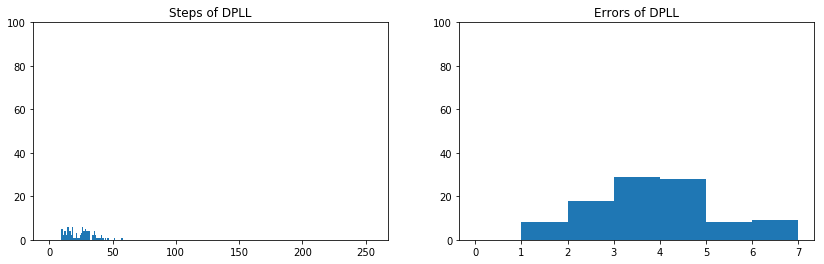

#Sats: 100; avg step: 23.85; stdev step: 11.12; avg error: 3.53; stdev error: 1.19


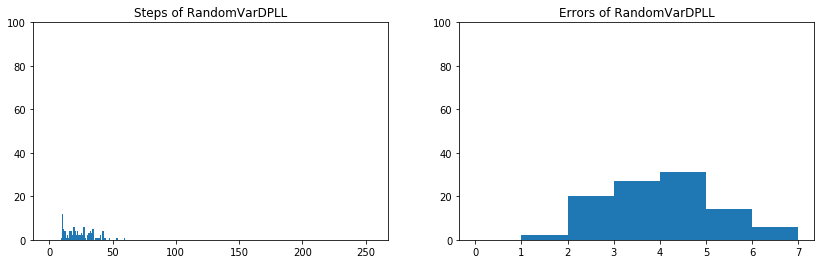

#Sats: 100; avg step: 17.94; stdev step: 8.64; avg error: 2.00; stdev error: 1.20


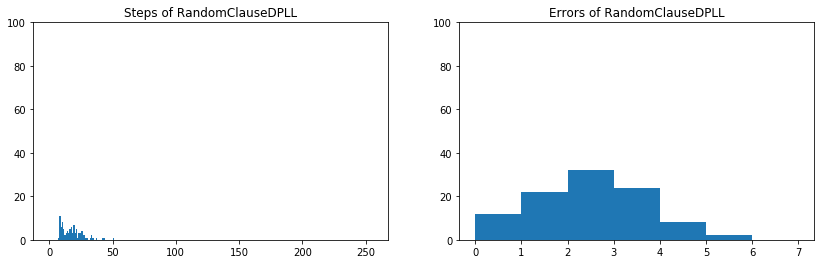

#Sats: 100; avg step: 13.09; stdev step: 8.47; avg error: 0.47; stdev error: 0.66


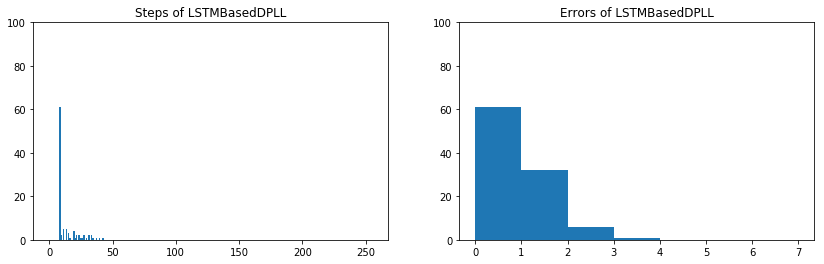

#Sats: 100; avg step: 10.33; stdev step: 4.04; avg error: 0.51; stdev error: 0.61


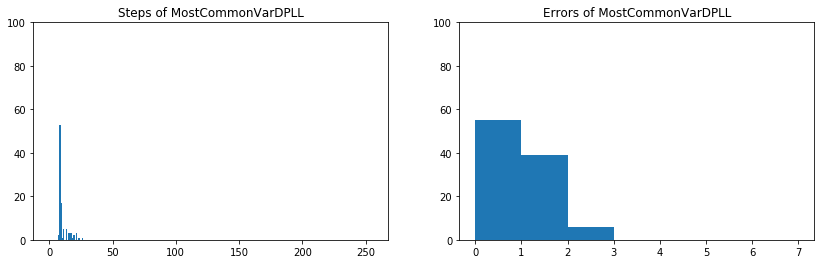

In [23]:
print_all(100, 3, 7, 70)

#Sats: 100; avg step: 37.41; stdev step: 26.64; avg error: 3.41; stdev error: 1.43


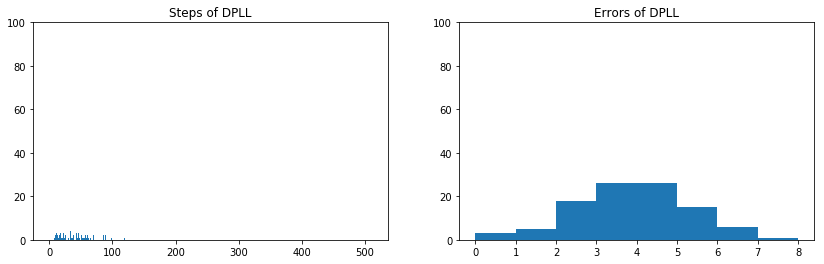

#Sats: 100; avg step: 36.23; stdev step: 20.34; avg error: 3.30; stdev error: 1.37


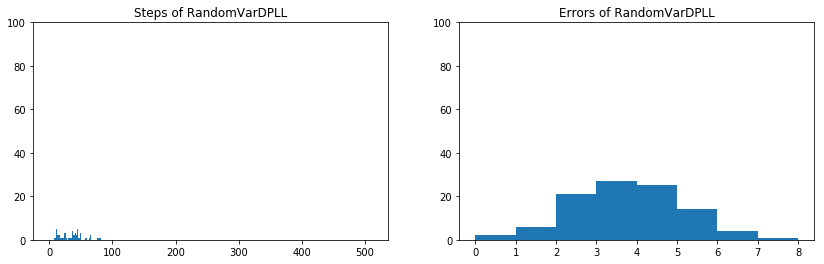

#Sats: 100; avg step: 31.36; stdev step: 20.47; avg error: 1.92; stdev error: 1.16


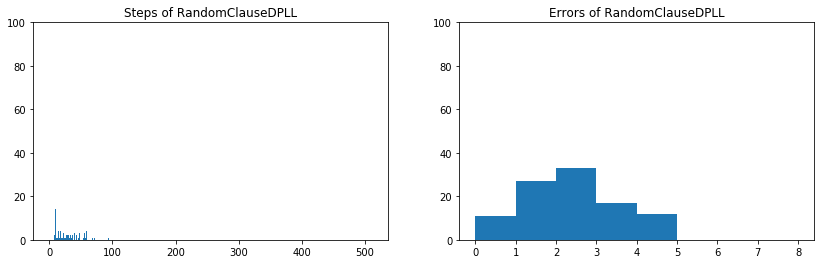

#Sats: 100; avg step: 26.40; stdev step: 26.78; avg error: 0.56; stdev error: 0.71


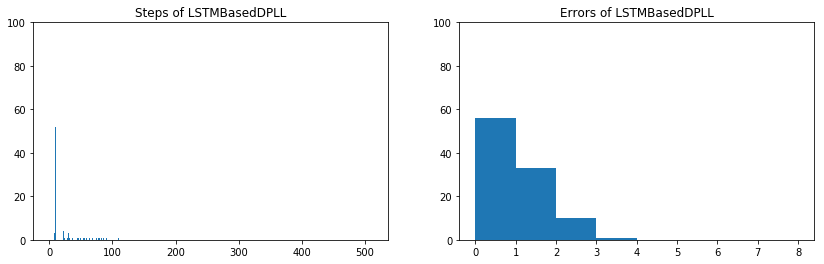

#Sats: 100; avg step: 15.00; stdev step: 11.19; avg error: 0.61; stdev error: 0.68


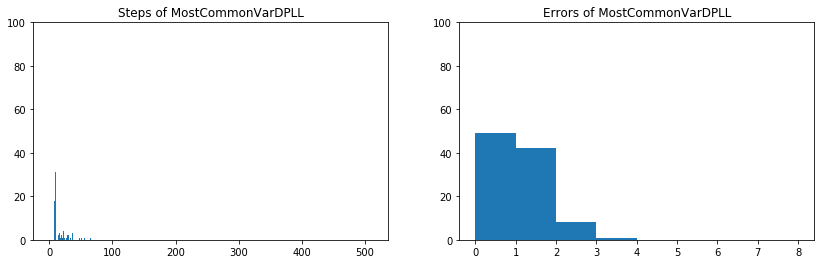

In [24]:
print_all(100, 3, 8, 40)

#Sats: 100; avg step: 39.02; stdev step: 25.95; avg error: 3.81; stdev error: 1.31


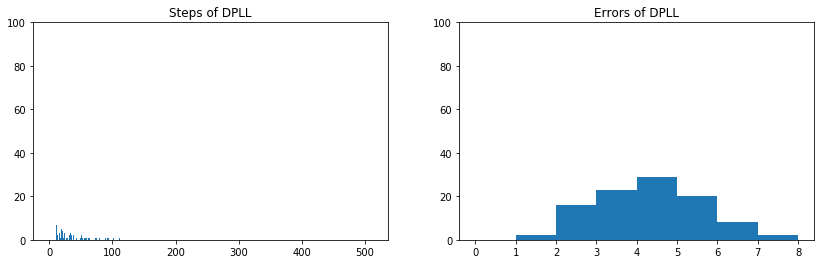

#Sats: 100; avg step: 39.30; stdev step: 19.77; avg error: 3.90; stdev error: 1.30


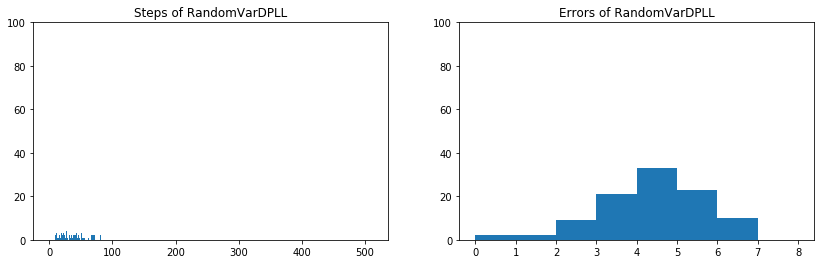

#Sats: 100; avg step: 27.76; stdev step: 17.30; avg error: 1.98; stdev error: 1.08


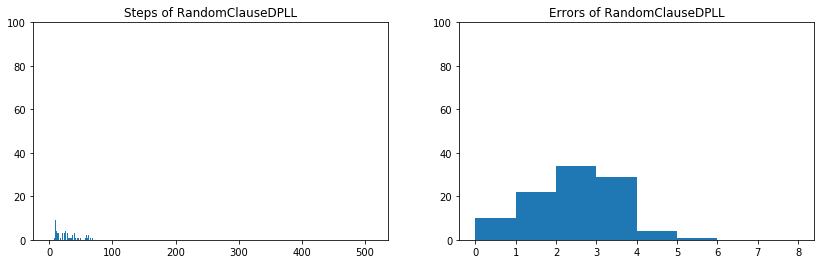

#Sats: 100; avg step: 20.04; stdev step: 21.25; avg error: 0.56; stdev error: 0.64


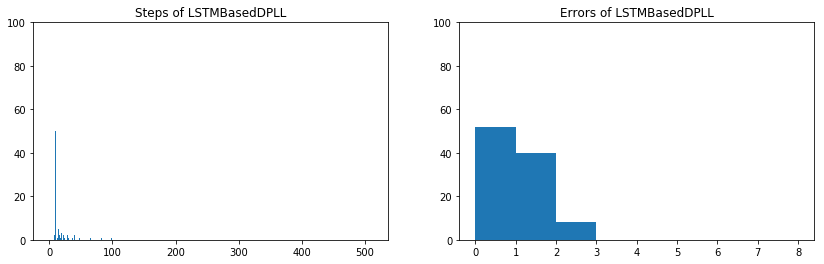

#Sats: 100; avg step: 15.08; stdev step: 10.87; avg error: 0.64; stdev error: 0.71


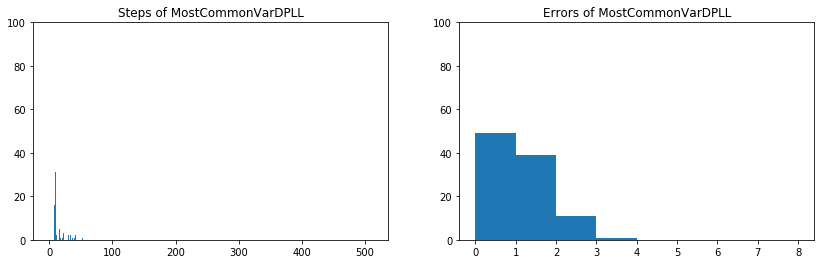

In [25]:
print_all(100, 3, 8, 50)